### Multiclass Classification Models in Keras  
As you recall, a classification problem is one in which you are trying to predict a discrete, finite, and non-overlapping number of classes.
Multiclass classification is when you are trying to predict which of 3 or more classes a sample belongs to. This is handled a little
differently in Keras models than binary classification, although most of the same metrics can apply. One example is a model that tries to
classify fish into a limited number of known species using measurements of size and weight. Let’s try this in Keras.!

Learning Objectives
After completing this lesson you will be able to:
1. Preprocess a multiclass target for a Keras deep learning model
2. Create a feed-forward model for multiclass classification using appropriate output layers, loss functions, and metrics in Keras
3. Evaluate a feed-forward multiclass classification model created in Keras using Sci-kit Learn metric functions  


Steps  
In this lesson we will:
1. Import necessary libraries
2. Load and process data,
3. One-hot encode the target variable
4. Build a feed-forward multiclass classification model with an appropriate output layer and loss function
5. Evaluate the model using classification metrics and a confusion matrix

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout

#Sci-kit Learn
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [21]:
# Learning history plotting function
def plot_history(history):
#Takes a keras model learning history and plots each metric

    metrics = history.history.keys()

    for metric in metrics:
        if not 'val' in metric:
            plt.plot(history.history[f'{metric}'], label=f'{metric}')

            if f'val_{metric}' in metrics:
                plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
            
            plt.legend()
            plt.title(f'{metric}')
            plt.show()

### Load and Process Data 
The data we will be using is collected from a fish market and represents data about nine different common fish species. It was originally
downloaded from Kaggle and originally provided by SAS OnDemand for Academics.
This dataset only has 159 rows and that would usually be too small for deep learning to be effective, however, it will work for
demonstration purposes.

In [4]:
# Load Data
multi_url = r"C:\Users\User\github_projects\Machine_Learning_with_Python\datasets\fish.csv"
df_multi = pd.read_csv(multi_url)
df_multi.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [5]:
# Check for duplicates and missing data
print(df_multi.info())
print(f'{df_multi.duplicated().sum()} duplicate rows')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  155 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  157 non-null    float64
 3   Length2  157 non-null    float64
 4   Length3  150 non-null    float64
 5   Height   156 non-null    float64
 6   Width    157 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB
None
0 duplicate rows


In [6]:
# Other than the target all of the columns are numeric and there are no duplicates. However, we have some rows with missing values.
# Let’s see how many rows are missing at least one value.
# count rows with missing values
na_rows = df_multi.isna().any(axis=1).sum()
print(f'{na_rows} rows are missing data')
print(f'{na_rows/len(df_multi)*100:.1f}% of rows are missing data')

20 rows are missing data
12.6% of rows are missing data


In [7]:
# This is more than 10% and normally we would try to impute these. However, we may worry that imputation errors will severely affect our
# model. We will try dropping them, but if we were going to continue with this project we might try both versions of the data, with dropped
# nulls and imputed nulls, to see which trains a better model.
# drop missing data
df_multi.dropna(inplace=True)
print(df_multi.info())

<class 'pandas.core.frame.DataFrame'>
Index: 139 entries, 0 to 157
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  139 non-null    object 
 1   Weight   139 non-null    float64
 2   Length1  139 non-null    float64
 3   Length2  139 non-null    float64
 4   Length3  139 non-null    float64
 5   Height   139 non-null    float64
 6   Width    139 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.7+ KB
None


In [8]:
# Since we are performing classification, we should always check our class balance to help us make decisions about data preparation and
# to help us properly interpret our accuracy scores.
# check class balance
df_multi['Species'].value_counts()

Species
Perch        48
Bream        30
Roach        16
Pike         13
Smelt        13
Parkki       11
Whitefish     6
Beam          2
Name: count, dtype: int64

In [9]:
# Our training set is very imbalanced. We could apply some balancing techniques, but with so few training instances it would be pointless
# to oversample or undersample the data. We could try SMOTE, but we might expect limited success. In this case, we will just leave it
# and hope for the best.
# There are also only 2 ‘Beam’ fish in the dataset. A Google search shows that there is no fish named a ‘Beam’. We will combine this
# with ‘Bream’
df_multi['Species'].replace('Beam', 'Bream', inplace=True)

In [10]:
# split data
X = df_multi.drop(columns='Species')
y = df_multi['Species']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [11]:
# We can also expect our accuracy score to be an unreliable measure of our model’s performance.
# Data features for deep learning should always be scaled to avoid exploding weights. Exploding weights causes some weights to grow
# very large and be given too much emphasis by the model. This can lead to overfitting problems.

# scale data
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

### Encode the Target
One important difference between binary classification and multiclass classification is how we encode the target. In binary classification,
we need to make sure that the two classes are encoded as 0 and 1.
In multiclass classification, we both numerically encode AND one-hot encode, or binarize, the target.
We will end up with 3 versions of the labels: original, numerically encoded, and binarized.

In [12]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
# encode labels
encoder = LabelEncoder()

encoder.fit(y_train)
y_train_enc = encoder.transform(y_train)
y_test_enc = encoder.transform(y_test)

# make a record of the classes, in order of the encoding, in case we want to
# translate predictions into fish names later.
classes = encoder.classes_

# binarize labels
binarizer = LabelBinarizer()

binarizer.fit(y_train_enc)
y_train_bin = binarizer.transform(y_train_enc)
y_test_bin = binarizer.transform(y_test_enc)

# check results
print('Original Target')
print(y_train.head())

print('\nEncoded Target')
print(y_train_enc[:5])

print('\nBinarized Target')
print(y_train_bin[:5])

Original Target
36     Roach
27     Bream
126    Perch
73     Perch
34     Bream
Name: Species, dtype: object

Encoded Target
[4 0 2 2 0]

Binarized Target
[[0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0]]


### Create the Keras Model
We are ready to create our model architecture. We will set the input dimensions to the number of features in the incoming training data
so Keras can create the correct implied input layer.
Some previous experiments have shown us that we need a model with some complexity, 2 hidden layers with 50 nodes each, but that
complexity also led to overfitting problems. We will use dropout layers to regularize our model to combat that. You will learn about
dropout layers in another lesson, but to suffice it to say they reduce overfitting.  


#### Output Layer
Also, notice our output layer. The number of nodes in the output layer must match the number of classes in the target. In this case, we
are classifying fish into 7 different species, so the output layer needs 7 nodes. Recall that we binarized our target to 7 columns so the
output predictions of the model will match the shape of the true labels. We’ve coded this algorithmically by using the length of the
number of classes from the encoder object. This avoids errors in case we change the number of classes earlier in the process for some
reason.
Finally, notice the activation function of the output layer. For multi-class classification, we use the ‘softmax’ activation. This outputs a
matrix of probabilities with each value in a row equal to the probability that the sample belongs to each of the classes. The output will
have 7 columns with 7 probabilities corresponding to the 7 different species of fish. Later during evaluation and prediction, we will
extract the index of the column with the highest probability and take that as the prediction.

In [13]:
# create model architecture

# define some parameters
input_dim = X_train_sc.shape[1]
num_classes = len(classes)

# instantiate the base model
multi_model = Sequential()

# add layers
multi_model.add(Dense(50, input_dim=input_dim, activation='relu'))
multi_model.add(Dropout(.3))
multi_model.add(Dense(50, activation='relu'))

multi_model.add(Dropout(.3))
multi_model.add(Dense(num_classes, activation='softmax'))
multi_model.summary()

# Before we train the model we need to compile it, to build it in the memory of our computer. We will define the loss, optimizer, and any
# additional metrics we want the compiler to keep track of for each epoch during training.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                350       
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 357       
                                                                 
Total params: 3257 (12.72 KB)
Trainable params: 3257 (12.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Loss
The loss for a Keras model performing multiclass classification will be ‘categorical_crossentropy’ when the target is binarized. There
are some ways to avoid binarizing the true labels, but they run into some other limitations. You would also use a different loss function if
the true labels were not binarized. If you want to know more about loss functions, what they do, and when each should be used, you
can research the documentation at: https://keras.io/api/losses/

### Optimizer
An optimizer can speed up learning, and Adam is a popular optimizer. We will start with that here. There are other optimizers you can
try that work with any kind of problem. You can research other options here: https://keras.io/api/optimizers/

### Metrics
The .compile() method lets us pass additional metrics to be tracked for each learning epoch. If we want to see how they change as the
model learns we can list them here.
This method recognizes some metrics as string shortcuts, such as ‘accuracy’, but others must be passed as class instances, such as
metrics.Recall(). These class instances work differently than the functions that Sci-kit learn offers for evaluation purposes. They fit on
the specific data for the model and should not be reused. Instantiate a new instance of each metrics class for each model iteration.
There is no native class for the f1-score metric, however, it’s possible to create custom metric classes. The code for some
implementations of the F1-score metric class is available online. They are a little complicated, but you could copy and paste them with
attribution if you wanted to.
You can learn more about available metrics here: https://keras.io/api/metrics/

In [14]:
# compile model with categorical_crossentropy

multi_model.compile(loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy',

metrics.Precision(),
metrics.Recall()])

Next, we will fit the model on the data and use the validation data to identify any overfitting. The model will evaluate itself using all
metrics passed in the .compile() call for every epoch on both sets of data, though it will only actually train on the training data. We will
also set verbose=0 to avoid the long output of learning metrics by epoch. If you want to see the training metrics in real-time, you can
change this argument.

In [16]:
# fit model

history = multi_model.fit(X_train_sc, y_train_bin,
                          validation_data=(X_test_sc, y_test_bin),
                          epochs=150,
                          verbose=0)

In [ ]:
# Next, we will fit the model on the data and use the validation data to identify any overfitting. The model will evaluate itself using all
# metrics passed in the .compile() call for every epoch on both sets of data, though it will only actually train on the training data. We will
# also set verbose=0 to avoid the long output of learning metrics by epoch. If you want to see the training metrics in real-time, you can
# change this argument.

In [19]:
# fit model

history = multi_model.fit(X_train_sc, y_train_bin,
                          validation_data=(X_test_sc, y_test_bin),
                          epochs=150,
                          verbose=0)

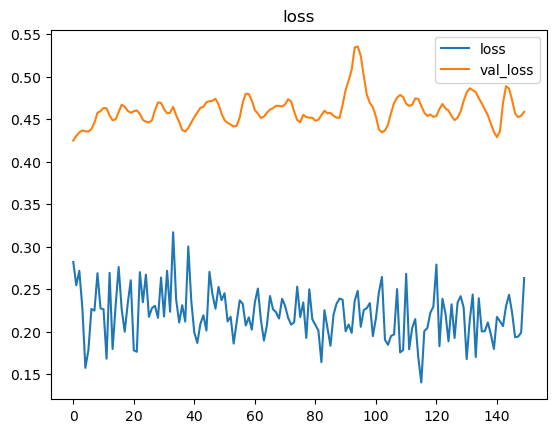

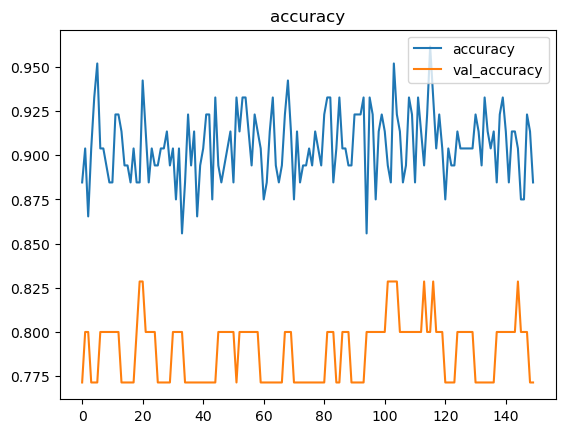

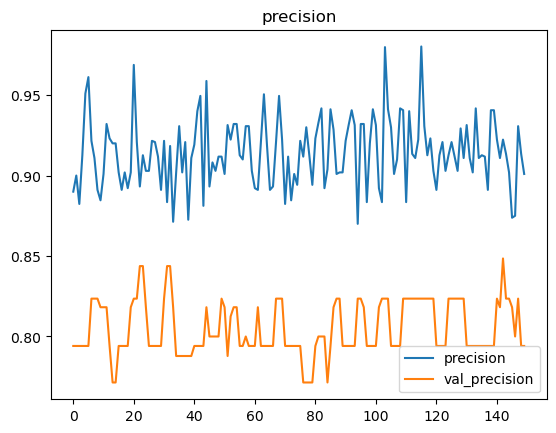

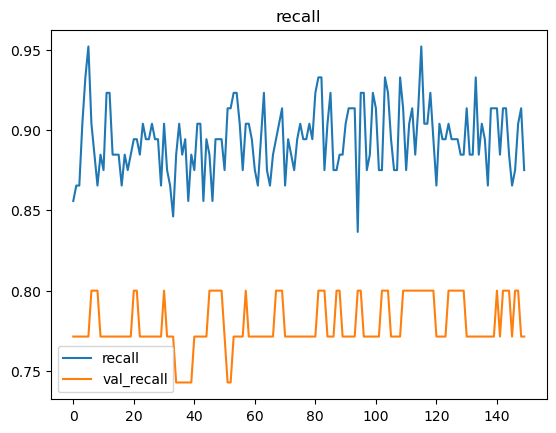

In [22]:
# plot learning history
plot_history(history)

# The learning converges on fairly good scores according to our accuracy, precision, and recall metrics. There is no severe underfitting.
# We also see that the final training scores and testing scores are pretty close. The model is not overfitting overly much.
# The metrics along the training history are somewhat bumpy. This is likely caused by the small dataset and class imbalance.

### Evaluate the Multiclass Classification Model  
There are some differences in how we need to process the model predictions to use Sci-Kit Learn evaluation functions. Sci-Kit learn
expects a one-dimensional array of predictions and labels, but our predictions and binarized labels are 2 dimensional. Each column
represents a different fish species and the values in each column represent the model’s estimation of the probability that the fish
belongs to that species.
Notice that these are represented in scientific notation. For example:
9.2e-03 = .0092
9.8e-01 = .98

In [23]:
# get raw predictions
raw_pred = multi_model.predict(X_test_sc)

# display predictions and binarized true labels
print('Raw Predictions\n', raw_pred[:5])
print('\nbinarized y_test\n', y_test_bin[:5])

2/2 [==============================] - 0s 5ms/step
Raw Predictions
 [[1.10477245e-07 1.40732708e-13 9.99531984e-01 9.25628046e-05
  4.43516122e-08 3.18929061e-08 3.75388801e-04]
 [1.22886745e-03 4.91915364e-03 3.05720031e-01 6.00362662e-04
  6.33923471e-01 2.67748279e-03 5.09306155e-02]
 [1.03135130e-06 2.35617335e-04 8.59410405e-01 1.70192448e-06
  1.24495007e-01 1.58361793e-02 1.99403985e-05]
 [5.01590362e-03 8.50297752e-08 7.85786450e-01 4.74990252e-03
  1.50688347e-05 1.73560711e-05 2.04415292e-01]
 [9.99996901e-01 3.00871898e-06 4.48797813e-12 2.37125879e-12
  1.73213721e-10 3.91418316e-13 1.18811059e-07]]

binarized y_test
 [[0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0]]


In [24]:
# To use these predictions in a Sci-kit Learn function, we need to convert them to the integer label for each fish. We can do that with
# np.argmax(data, axis=1). This will return the column index for the highest value in each row. That column index corresponds to the fish
# species.
# convert predictions and labels into integers representing each fish class.
y_pred = np.argmax(raw_pred, axis=1)
y_true = np.argmax(y_test_bin, axis=1)

print('integer predictions', y_pred)
print('integer true labels', y_true)

integer predictions [2 4 2 2 0 2 5 3 2 0 2 0 3 2 0 2 2 2 2 0 1 3 1 2 2 2 5 0 0 1 4 0 2 2 2]
integer true labels [2 2 2 6 0 2 5 3 2 0 2 0 3 2 0 4 2 2 4 0 1 3 1 4 4 2 5 0 0 1 6 0 5 2 2]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         3
           2       0.65      0.92      0.76        12
           3       1.00      1.00      1.00         3
           4       0.00      0.00      0.00         4
           5       1.00      0.67      0.80         3
           6       0.00      0.00      0.00         2

    accuracy                           0.77        35
   macro avg       0.66      0.65      0.65        35
weighted avg       0.71      0.77      0.73        35



c:\Users\User\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


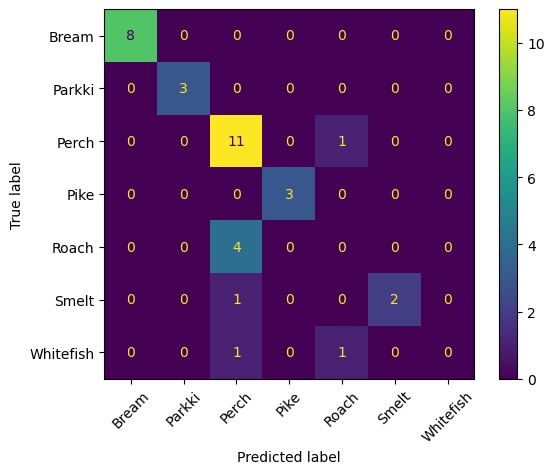

In [25]:
# Now we are ready to use Sci-kit learn tools to evaluate our model. Let’s use a classification report and a confusion matrix.
# print classification report and confusion matrix

print(classification_report(y_true, y_pred))

ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                        display_labels=classes,
                                        xticks_rotation=45)

### Model Evaluation
Our model correctly classified 83% of the fish, however, it was unable to classify Whitefish or Roaches. This is likely because there are
very few of those fish in the dataset. Again, we run into the problems of a too-small dataset.
The notebook with the code for this lesson is available here.
Note, due to the stochastic nature of deep learning models, you may not get the same results as this lesson, and the notebook
outputs may not match.

### Summary
Multiclass classification in Keras has some special requirements. The labels should be binarized, or one-hot encoded. The final output
layer must have a number of nodes equal to the number of classes and an activation function of ‘softmax’. When compiling the model,
the loss function should be ‘categorical_crossentropy’. When evaluating the model using Sci-kit Learn metrics functions it is first
necessary to convert the 2-dimensional prediction and label arrays to one dimension by using np.argmax(data, axis=1). Once these are
done you can proceed with evaluation in the same way as you would with traditional Sci-kit Learn models.